<a href="https://colab.research.google.com/github/JoeriHHS/Portfolio/blob/main/MachineLearningOpdracht.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning opdracht
#### Joeri Meijers (20123558)

De opdracht bestaat uit 2 verschillende onderdelen. De rest van dit script zal uit 3 verschillende onderdelen bestaan. Als eerst zal de data worden ingeladen en worden bestudeerd, vervolgens zal het eerste deel van de opdracht worden uitgewerkt en tot slot zal het tweede deel van de opdracht worden uitgewerkt. De opdracht is het adviseren van een makelaar op de Nederlandse huizenmarkt. Daarvoor hebben we beschikking over een dataset van de website Funda.nl. De opdracht bestaat uit 2 onderdelen; het maken van een model dat de prijs van de huizen voorspelt en het maken van een model dat voorspelt of een huis binnen 14 dagen verkocht gaat worden.

## Data analyse

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
import math
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as ov
import matplotlib
from sklearn.linear_model import Lasso
from sklearn.utils import resample

In [ ]:
df = pd.read_csv('dataset_funda.csv')
df["Aantal dagen tot verkoop"] = df["Aantal dagen tot verkoop"].apply(lambda x: int(x[:-5]))
df = df.select_dtypes(include=['number'])
df = df.drop('Vraagprijs per m2', axis=1)
df

,Laatste vraagprijs,Aantal kamers,Overige inpandige ruimte m2,Perceel m2,Achtertuin m2,Aantal dagen tot verkoop,Woonruimte in m2,Gebouwgebonden buitenruimte in m2,Externe bergruimte in m2,Inhoud in m3,...,Soort garage_Parkeerplaats,Soort garage_Inpandig,Soort garage_Parkeerkelder,Soort garage_Garagebox,Soort garage_Aangebouwdestenen garage,Soort garage_Carport,Soort garage_Vrijstaandestenen garage,Soort garage_Vrijstaandehouten garage,Soort garage_Garagemet carport,Soort garage_Souterrain
0,485000,5,18,263,120,295,151,0,0,625,...,0,0,0,0,0,0,0,0,0,0
1,375000,5,0,198,60,269,117,0,5,415,...,1,0,0,0,0,0,0,0,0,0
2,279500,3,4,128,68,113,94,0,0,365,...,0,0,0,0,0,0,0,0,0,0
3,2330000,8,0,2479,2172,158,307,0,0,921,...,1,0,0,0,0,0,0,0,0,0
4,2270000,8,0,1796,1489,164,307,0,0,921,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879,494449,6,16,653,477,26,150,4,22,646,...,1,0,0,0,0,0,1,0,0,0
9880,425000,5,61,356,75,56,109,0,0,619,...,0,1,0,0,0,0,0,0,0,0
9881,279500,4,10,119,30,28,132,8,0,540,...,0,0,0,0,0,0,0,0,0,0
9882,365000,5,0,178,63,21,118,13,8,405,...,0,0,0,0,0,0,0,0,0,0


In de tabel staan een hoop waardes waar een machine learning model niet zoveel mee kan. Het eerste wat ik doe is het filteren van de tabel op alleen nummerieke waarden. De variabele aantal dagen tot verkoop wordt zo genoteerd dat alleen het aantal dagen nog in de cellen staan. Ook de kolom met daarin de vraagprijs per m2 verwijderen we uit het model. De reden hiervoor is dat de vraagprijs per m2 pas bekend is op het moment dat de laatste vraagprijs bekend is. In de toekomst zal een makelaar niks hebben aan een model die deze variabele meeneemt omdat deze informatie op voorhand niet bekend is, maar pas bekend wordt zodra de verkoopprijs bekend is.

In [ ]:
#Om te bekijken of er nog missende waarden in de dataset zitten.
df.isna().sum().sum()

0

In [ ]:
#Hier staat informatie over de doelvariabele
pd.options.display.float_format = '{:.3f}'.format
df["Laatste vraagprijs"].describe()

count      9884.000
mean     440570.096
std      223982.926
min       75000.000
25%      300000.000
50%      389000.000
75%      510000.000
max     2950000.000
Name: Laatste vraagprijs, dtype: float64

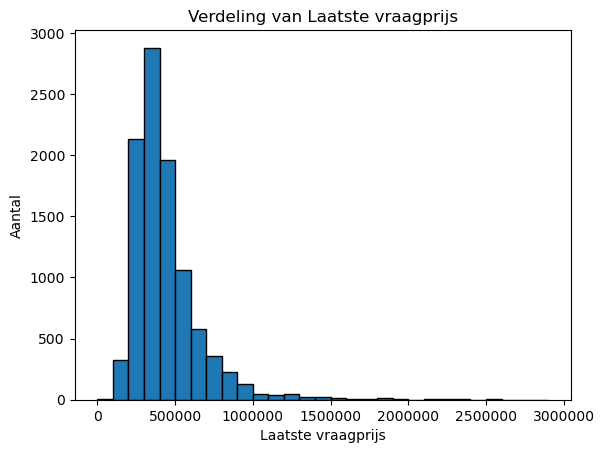

In [ ]:
#Ik was benieuwd naar de verdeling van de huizenprijzen. Je ziet duidelijk dat de meeste huizen worden verkocht voor minder dan 1 miljoen euro en enkele huizen voor meer dan 1 miljoen euro.
plt.hist(df["Laatste vraagprijs"], bins=range(0, 3000000, 100000), edgecolor='k')
plt.xlabel("Laatste vraagprijs")
plt.ylabel("Aantal")
plt.title("Verdeling van Laatste vraagprijs")
plt.ticklabel_format(style='plain', axis='both')
plt.show()

In [ ]:
#Dit zijn de correlaties van de variabelen met de doelvariabele.
df.corr()['Laatste vraagprijs']

Laatste vraagprijs                      1.000
Aantal kamers                           0.404
Overige inpandige ruimte m2             0.190
Perceel m2                              0.266
Achtertuin m2                           0.227
                                         ... 
Soort garage_Carport                    0.058
Soort garage_Vrijstaandestenen garage   0.078
Soort garage_Vrijstaandehouten garage   0.047
Soort garage_Garagemet carport          0.004
Soort garage_Souterrain                 0.060
Name: Laatste vraagprijs, Length: 104, dtype: float64

In [ ]:
#Vervolgens worden alle variabelen opgeslagen in een lijst waarvan de correlatie met de laatste vraagprijs meer is dan 0.1 of lager is dan 0.1.
correlaties = df.corr()['Laatste vraagprijs'].sort_values(ascending=False)
geselcteerde_variabelen = correlaties[(correlaties > 0.1) | (correlaties < -0.11)]
sterk_correlatie = geselcteerde_variabelen.index.tolist()[1:] #vanaf de tweede rij omdat op de eerste rij de doelvariabele staat.

### Voor opdracht deel 2

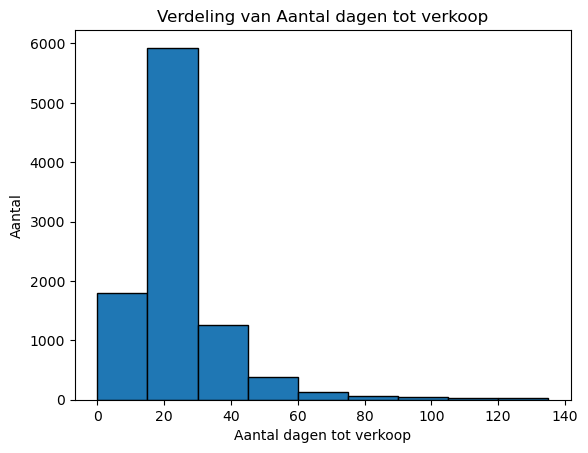

In [ ]:
#Dit is de verdeling van de aantal dagen tot verkoop. De eerste bin zijn de huizen die binnen 14 dagen verkocht worden. Er zijn ook huizen die na 120+ dagen vrekocht werden, maar dat maakte de grafeik heel onduidelijk dus vandaar dat er een maximum zit op 150.
plt.hist(df["Aantal dagen tot verkoop"], bins= range(0,150, 15), edgecolor='k')
plt.xlabel("Aantal dagen tot verkoop")
plt.ylabel("Aantal")
plt.title("Verdeling van Aantal dagen tot verkoop")
plt.ticklabel_format(style='plain', axis='both')
plt.show()

In [ ]:
#Hier splits ik de totale data in een df en een validdf. Met de validdf kan ik na het testen nog controleren of het model niet overfit op de testset.
df, validdf = train_test_split(df, test_size = 0.1)

## Opdracht deel 1

Voor de eerste opdracht is er gevraagd of we een model kunnen maken die een voorspelling kan maken van de huizenprijs. We mogen daarbij aannemen dat de variabele 'Laatste vraagprijs' de uiteindelijke huizenprijs is. De dataset heeft ontzettend veel verschillende variabelen en ik denk dat niet alle variabelen even relevant zijn. Om dat aan te tonen hebben we modellen gebouwd met data die alleen sterk correleert met de doelvariabele en modellen alle beschikbare data.

Omdat wij bij het project modelleren gebruik maken van de RandomForestRegressor, wilde ik dit model ook toepassen op dit probleem. Ik wilde het model gaan vergelijken met de LinearRegression.

### Model 1; LinearRegression met alle data

Eerst maak ik 1 keer een model aan en bereken ik de RMSE en de R2-score. Daarna doe ik dit 100 keer met elke keer een andere samenstelling van de train en test set en bereken ik het gemiddelde van de RMSE en de R2-score.

In [ ]:
X = df.drop("Laatste vraagprijs", axis = 1)
y = df["Laatste vraagprijs"]
#Train test split om de dataset te splitten in een trainingsdeel en een testdeel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Model aanamken, trainen en y_pred berekenen
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Model evalueren op basis van de RMSE en de r2-score
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Voor model 1; de LinearRegression met alle data kom ik op een RMSE van: {rmse}, en een R2-score van: {r2}.')

Voor model 1; de LinearRegression met alle data kom ik op een RMSE van: 139632.75657230607, en een R2-score van: 0.5845007312025419.


In [ ]:
rmselist = []
r2list = []
for i in range(100):
    X = df.drop("Laatste vraagprijs", axis = 1)
    y = df["Laatste vraagprijs"]
    #Train test split om de dataset te splitten in een trainingsdeel en een testdeel
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    #Model aanamken, trainen en y_pred berekenen
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Model evalueren op basis van de RMSE en de r2-score
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    rmselist.append(rmse)
    r2list.append(r2)
print(f'Voor 100 iteraties komt er uit dit model een gemiddelde RMSE van: {sum(rmselist)/len(rmselist)} en een gemiddelde R2-score van: {sum(r2list)/len(r2list)}.')

Voor 100 iteraties komt er uit dit model een gemiddelde RMSE van: 140691.95144260963 en een gemiddelde R2-score van: 0.6058316338826951.


Over 100 iteraties presteert het model alleen maar beter, dat kunnen we zien omdat de RMSE kleiner wordt en de R2-score juist groter wordt.

### Model 2; LinearRegression met sterk correlerende variabelen

In [ ]:
X = df[sterk_correlatie]
y = df["Laatste vraagprijs"]
#Train test split om de dataset te splitten in een trainingsdeel en een testdeel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Model aanamken, trainen en y_pred berekenen
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Model evalueren op basis van de RMSE en de r2-score
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Voor model 2; de LinearRegression met sterk gecorreleerde data komen wij op een RMSE van: {rmse}, en een R2-score van: {r2}.')

Voor model 2; de LinearRegression met sterk gecorreleerde data komen wij op een RMSE van: 144766.42101475754, en een R2-score van: 0.5533870459200767.


In [ ]:
rmselist = []
r2list = []
for i in range(100):
    X = df[sterk_correlatie]
    y = df["Laatste vraagprijs"]
    #Train test split om de dataset te splitten in een trainingsdeel en een testdeel
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    #Model aanamken, trainen en y_pred berekenen
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Model evalueren op basis van de RMSE en de r2-score
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    rmselist.append(rmse)
    r2list.append(r2)
print(f'Voor 100 iteraties komt er uit dit model een gemiddelde RMSE van: {sum(rmselist)/len(rmselist)} en een gemiddelde R2-score van: {sum(r2list)/len(r2list)}.')

Voor 100 iteraties komt er uit dit model een gemiddelde RMSE van: 145756.74902080922 en een gemiddelde R2-score van: 0.5727077671265061.


Over 100 iteraties presteert het model alleen maar beter, dat kunnen we zien omdat de RMSE kleiner wordt en de R2-score juist groter wordt.

### Model 3; RandomForestRegression met alle data

Dit model gerbuiken wij bij ons modelleren project voor het voorspellen van het ziekteverloop van een patient met CIDP. ik ben benieuwd of dit model goed werkt op dit probleem. Dit model heeft vershcillende hyperparameters die ik kan tunen. Ik heb ervoor gekozen om een trial uit te voeren om de optimale waardes voor de max_depth en n_estimators te vinden.

In [ ]:
X = df.drop("Laatste vraagprijs", axis = 1)
y = df["Laatste vraagprijs"]
#Train test split om de dataset te splitten in een trainingsdeel en een testdeel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Dit is de functie voor het aanmaken van de trial
def trial(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32) #De max_depth die wordt gekozen tussen de 2 en 32.
    n_estimators = trial.suggest_int('n_estimators', 10, 200) #De n_estimators wordt gekozen tussen de 10 en 200.
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state = 42) #Aanmaken van het model, trainen en y_pred berekenen
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred)) #De R2 en de rmse worden berekend, voor nu werkt de trial alleen met 1 output, dus kiezen we in dit geval voor de R2 score.
    r2 = r2_score(y_test, y_pred)
    return r2

#het lukte mij niet om de trial met behulp van de pipetorch library uit te voeren, dus heb ik op internet naar een andere manier gezocht en kwam ik uit op deze manier.
if __name__ == "__main__":
    study = optuna.create_study(direction= "maximize")  # ik probeer de RMSE te minimaliseren en de r2 te maximaliseren
    study.optimize(trial ,n_trials=10)  # Aantal trials aanpassen naar behoefte, we doen nu 10 trials omdat dit "lang" duurt

    #Toon de beste hyperparameters en beste RMSE/r2
    best_params = study.best_params
    #best_rmse = study.best_value
    best_r2 = study.best_value
    print("Beste hyperparameters:", best_params)
    #print("Beste RMSE:", best_rmse)
    print("Beste R2:", best_r2)

[I 2023-10-29 20:14:45,239] A new study created in memory with name: no-name-1426aa56-1ed1-4cba-b565-24ca57a53d10
[I 2023-10-29 20:14:47,244] Trial 0 finished with value: 0.5911428857501931 and parameters: {'max_depth': 25, 'n_estimators': 42}. Best is trial 0 with value: 0.5911428857501931.
[I 2023-10-29 20:14:53,440] Trial 1 finished with value: 0.5965480659672389 and parameters: {'max_depth': 23, 'n_estimators': 136}. Best is trial 1 with value: 0.5965480659672389.
[I 2023-10-29 20:14:56,387] Trial 2 finished with value: 0.5889416098177559 and parameters: {'max_depth': 26, 'n_estimators': 63}. Best is trial 1 with value: 0.5965480659672389.
[I 2023-10-29 20:14:57,915] Trial 3 finished with value: 0.5848429380425684 and parameters: {'max_depth': 11, 'n_estimators': 58}. Best is trial 1 with value: 0.5965480659672389.
[I 2023-10-29 20:15:00,590] Trial 4 finished with value: 0.5787965649850686 and parameters: {'max_depth': 8, 'n_estimators': 141}. Best is trial 1 with value: 0.59654806

Beste hyperparameters: {'max_depth': 16, 'n_estimators': 177}
Beste R2: 0.5983147195190202


### Model 4; RandomForestRegressor met sterk correlerende variabelen

In [ ]:
X = df[sterk_correlatie]
y = df["Laatste vraagprijs"]
#Train test split om de dataset te splitten in een trainingsdeel en een testdeel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Dit is de functie voor het aanmaken van de trial
def trial(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32) #De max_depth die wordt gekozen tussen de 2 en 32.
    n_estimators = trial.suggest_int('n_estimators', 10, 200) #De n_estimators wordt gekozen tussen de 10 en 200.
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state = 42) #Aanmaken van het model, trainen en y_pred berekenen
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred)) #De R2 en de rmse worden berekend, voor nu werkt de trial alleen met 1 output, dus kiezen we in dit geval voor de R2 score.
    r2 = r2_score(y_test, y_pred)
    return r2

if __name__ == "__main__":
    study = optuna.create_study(direction= "maximize")  # We proberen de RMSE te minimaliseren en de r2 te maximaliseren
    study.optimize(trial ,n_trials=10)  # Aantal trials aanpassen naar behoefte, we doen nu 50 trials omdat dit "lang" duurt

    # Toon de beste hyperparameters en beste RMSE/r2
    best_params = study.best_params
    #best_rmse = study.best_value
    best_r2 = study.best_value
    print("Beste hyperparameters:", best_params)
    #print("Beste RMSE:", best_rmse)
    print("Beste R2:", best_r2)

[I 2023-10-29 20:13:10,057] A new study created in memory with name: no-name-f9a2c77d-8055-4bad-b9c6-77ec9f613bf2
[I 2023-10-29 20:13:11,908] Trial 0 finished with value: 0.5727740890878992 and parameters: {'max_depth': 8, 'n_estimators': 166}. Best is trial 0 with value: 0.5727740890878992.
[I 2023-10-29 20:13:15,060] Trial 1 finished with value: 0.5835891832295683 and parameters: {'max_depth': 23, 'n_estimators': 128}. Best is trial 1 with value: 0.5835891832295683.
[I 2023-10-29 20:13:16,398] Trial 2 finished with value: 0.5868375527431288 and parameters: {'max_depth': 15, 'n_estimators': 68}. Best is trial 2 with value: 0.5868375527431288.
[I 2023-10-29 20:13:20,741] Trial 3 finished with value: 0.5841581776905859 and parameters: {'max_depth': 23, 'n_estimators': 177}. Best is trial 2 with value: 0.5868375527431288.
[I 2023-10-29 20:13:23,054] Trial 4 finished with value: 0.5844497993487527 and parameters: {'max_depth': 29, 'n_estimators': 91}. Best is trial 2 with value: 0.5868375

Beste hyperparameters: {'max_depth': 15, 'n_estimators': 68}
Beste R2: 0.5868375527431288


In [ ]:
X_valid = validdf.drop('Laatste vraagprijs', axis = 1)
y_valid = validdf['Laatste vraagprijs']
X = df.drop("Laatste vraagprijs", axis = 1)
y = df["Laatste vraagprijs"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


model = RandomForestRegressor(max_depth = 16, n_estimators = 177, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

y_pred_valid = model.predict(X_valid)
r2_valid = r2_score(y_valid, y_pred_valid)
rmse_valid = math.sqrt(mean_squared_error(y_valid, y_pred_valid))
print("De uitkomsten van de validatieset:")
print(r2_valid, rmse_valid)

De uitkomsten van de validatieset:
0.6169498838337826 136779.90797407742


### Conclusie

Ik heb meerdere opties uitgevoerd en geprobeerd. De beste scores komen uit het model waar ik LinearRegression heb toegepast en het gemiddelde van 100 trials hebben berekend. De gemiddelde R2-score komt elke keer uit rond de 0.60, de RMSE komt elke keer rond de 140000. Ik ben hier niet helemaal tevreden over, als we bijvoorbeeld naar de RMSE kijken, dan zit de output van mijn model er gemiddeld zo'n 140000 euro naast. Als we dan de verdeling zien van de bedragen die we bij de data-analyse hebben laten zien, dan vind ik 140000 euro wel heel erg veel. Zeker omdat we zien dat de meeste huizen verkocht worden voor een bedrag tussen de 300000 en 400000. Ik heb geprobeerd om ook met Lasso en Ridge regressies een beter voorspelling te maken omdat ik misschien teveel variabelen meeneem, maar daar kwamen niet betere scores uit. Ook uit de validatieset komt een gemiddelde fout van 140000 euro.

## Opdracht deel 2

Voor deel 2 van deze opdracht moet er een model worden gemaakt die kan voorspellen of een huis verkocht wordt binnen 14 dagen. Dit is een classificatieprobleem, het huis wordt wel of niet verkocht binnen 14 dagen. Dat betekend dat de deolvariabele zo moet worden omgezet dat deze een 1 of 0 aanneemt. De eerste stap is het maken van een simpel model.

In [ ]:
#Het is duidelijk dat het hier gaat om een classificatieprobleem, een huis wordt wel of wordt niet binnen 14 dagen verkocht.
#Vandaar dat de doelvariabele wordt aangepast naar een 1 of een 0. Een 1 als het binnen 14 dagen wordt verkocht, een 0 als dat niet is gelukt.
df['Aantal dagen tot verkoop'] = df['Aantal dagen tot verkoop'].apply(lambda x: 1 if x <= 14 else 0)
validdf['Aantal dagen tot verkoop'] = validdf['Aantal dagen tot verkoop'].apply(lambda x: 1 if x <= 14 else 0)

In [ ]:
#Stap 1; Een simpel model
X = df.drop('Aantal dagen tot verkoop', axis = 1)
y = df['Aantal dagen tot verkoop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Maak een LogisticRegression model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(matrix, acc)

[[2170    2]
 [ 497    0]] 0.8130385912326714


In [ ]:
print(y_pred)
print(y_test.value_counts())

[0 0 0 ... 0 0 0]
0    2172
1     497
Name: Aantal dagen tot verkoop, dtype: int64


Als ik naar de accuracy score alleen kijk, lijkt het alsof het model het goed doet. Maar als ik ook naar de confusion matrix ga kijken, dan zien we dat het model alleen maar een 0 als uitkomst geeft. Omdat er in de dataset veel meer huizen zijn die niet binnen 14 dagen worden verkocht, zorgt dat voor een accuracy score van meer dan 81%. Dit kan worden opgelost door de data te gaan balanceren. Dit mag je alleen doen op de training data.  

In [ ]:
#Het balanceren van de data is de volgende stap.
train, test = train_test_split(df, test_size=0.2, random_state=42)
pd.Series(train['Aantal dagen tot verkoop']).value_counts()

0    5834
1    1282
Name: Aantal dagen tot verkoop, dtype: int64

In [ ]:
#hier wordt het aantal berekend voor het balanceren.
aantal = len(pd.Series(train['Aantal dagen tot verkoop'])) - pd.Series(train['Aantal dagen tot verkoop']).sum()

In [ ]:
train_resampled = pd.concat([train[train['Aantal dagen tot verkoop']==0],
                             resample(train[train['Aantal dagen tot verkoop']==1], n_samples=aantal)])

In [ ]:
train_resampled['Aantal dagen tot verkoop'].value_counts()

0    5834
1    5834
Name: Aantal dagen tot verkoop, dtype: int64

In [ ]:
X_train = train_resampled.drop(columns='Aantal dagen tot verkoop').to_numpy()
y_train = train_resampled['Aantal dagen tot verkoop'].to_numpy()
X_test = test.drop(columns='Aantal dagen tot verkoop').to_numpy()
y_test = test['Aantal dagen tot verkoop'].to_numpy()

#Opnieuw een LogisticRegression fitten op deze data
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(matrix, acc)
print(f1_score(y_test, y_pred))

[[ 270 1187]
 [  58  264]] 0.30016863406408095
0.2978003384094754


Nu zien we dat het model nog minder goed scoort, maar het model schat niet meer dat alle huizen niet binnen 14 dagen verkocht worden. Ik neem nog steeds alle data mee. Voor de LogisticRegression kan ik een model maken die het gewicht van de coefficienten die minder relevant zijn naar 0 halen. Dat model ga ik nu toepassen om te kijken of het een verbetering opleverd.

In [ ]:
#Door in de LogisticRegression de penalty mee te geven haalt dat de coefficienten naar 0.
model = LogisticRegression(penalty='l1', solver = 'liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
print(matrix, acc)
print(f1_score(y_test, y_pred))

[[752 705]
 [146 176]] 0.5216413715570545
0.29260182876142976


Er is te zien dat het model het weer wat beter doet. Een accuracy score van 53%. De volgende stap is dat ik een ander model ga proberen. Ik wil het RandomForestClassifier model hier op loslaten, eerst simpel en daarna de hyperparameters tunen. Als daar betere uitkomsten uitkomen gaan we het model valideren met de validatieset en anders gebruiken we het model hierboven.

In [ ]:
#Eerst een simpel RandomForestClassifier fitten en evalueren.
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
print(matrix, acc)
print(f1_score(y_test, y_pred))

[[1442   15]
 [ 315    7]] 0.8145025295109612
0.040697674418604654


Hierboven zien we dat er maar 15 keer wordt voorspeld dat een huis binnen 14 dagen verkocht wordt. Dat zijn er natuurlijk veel meer, dus ook dit model is nog niet optimaal. Volgende stap is om de hyperparamers te tunen

In [ ]:
#Hier heb ik een zelfde functie geschreven als bij de vorige hyperparameter tuning, maar dan voor een classifier.
def trial(trial):
    max_depth = trial.suggest_int('max_depth', 2, 40)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(trial, n_trials=10)

    # Toon de beste hyperparameters en beste nauwkeurigheid
    best_params = study.best_params
    #best_accuracy = study.best_value
    best_f1 = study.best_value
    print("Beste hyperparameters:", best_params)
    #print("Beste nauwkeurigheid:", best_accuracy)
    print("Beste f1:", best_f1)


[I 2023-10-29 20:19:01,543] A new study created in memory with name: no-name-90ee84fe-3fcc-4796-bea9-e841d4091855
[I 2023-10-29 20:19:01,775] Trial 0 finished with value: 0.27264239028944914 and parameters: {'max_depth': 9, 'n_estimators': 34}. Best is trial 0 with value: 0.27264239028944914.
[I 2023-10-29 20:19:02,184] Trial 1 finished with value: 0.2868277474668745 and parameters: {'max_depth': 6, 'n_estimators': 98}. Best is trial 1 with value: 0.2868277474668745.
[I 2023-10-29 20:19:02,505] Trial 2 finished with value: 0.16568047337278105 and parameters: {'max_depth': 19, 'n_estimators': 33}. Best is trial 1 with value: 0.2868277474668745.
[I 2023-10-29 20:19:03,722] Trial 3 finished with value: 0.16666666666666666 and parameters: {'max_depth': 15, 'n_estimators': 143}. Best is trial 1 with value: 0.2868277474668745.
[I 2023-10-29 20:19:04,647] Trial 4 finished with value: 0.2732447817836813 and parameters: {'max_depth': 9, 'n_estimators': 168}. Best is trial 1 with value: 0.286827

Beste hyperparameters: {'max_depth': 6, 'n_estimators': 54}
Beste f1: 0.2920152091254753


In [ ]:
#Het beste model nog beoordelen aan de hand van de validatieset
X_valid = validdf.drop('Aantal dagen tot verkoop', axis = 1)
y_valid = validdf['Aantal dagen tot verkoop']

model = RandomForestClassifier(max_depth = 6, n_estimators = 54, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("De uitkomsten van trainen en testen:")
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_pred_valid = model.predict(X_valid)
print("")
print("De uitkomsten van validatie:")
print(accuracy_score(y_valid, y_pred_valid))
print(confusion_matrix(y_valid, y_pred_valid))
print(f1_score(y_valid, y_pred_valid))

De uitkomsten van trainen en testen:
0.47667228780213605
[[656 801]
 [130 192]]
0.2920152091254753

De uitkomsten van validatie:
0.5156723963599595
[[393 410]
 [ 69 117]]
0.3281907433380084


/Users/gebruiker/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Op de validatieset zien we ingeveer dezelfde uitkomsten dus wordt er niet overfit op de test en training set.

### Conclusie

Uiteindelijk heb ik een aantal modellen geprobeerd, van de modellen heb ik de hyperparameters getuned, maar ik kom niet op hele indrukwekkende scores uit. De acuuracy score is elke keer richting de 60% en dat betekend dat het model beter voorspeld dan het opgooeien van een muntje. Maar ik denk dat het model nog zeker verbeterd moet worden voordat een makelaar dit model kan gaan gebruiken voor het voorspellen of een huis binnen 14 dagen verkocht gaat worden of niet.

##### Joeri Meijers 20123558

Ik heb mijn best gedaan om het zo duidelijk mogelijk te noteren allemaal. Mochten er nog vragen over zijn dan hoor ik die graag.